1.Data Loading

In [ ]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 10.1 MB/s eta 0:00:00


In [ ]:
# 1. Imports and setup
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, isnan, isnull, count, when, udf
from pyspark.sql.types import StringType
from pyspark.sql.window import Window
from pyspark.sql.functions import countDistinct
from pyspark.ml.feature import RegexTokenizer

import re
import string
import emoji

# Initialize Spark session
spark = SparkSession.builder.appName("TwitterSentimentAnalysis").getOrCreate()

# Load the CSV files with column names
columns = ['id', 'entity', 'sentiment', 'tweet']
train_df = spark.read.csv('/content/twitter_training.csv', header=False, inferSchema=True).toDF(*columns)
test_df = spark.read.csv('/content/twitter_validation.csv', header=False, inferSchema=True).toDF(*columns)

# Select only 'sentiment' and 'tweet' columns
train_df = train_df.select("sentiment", "tweet")
test_df = test_df.select("sentiment", "tweet")

# Combine train and test DataFrames
tweets_df = train_df.union(test_df)

# Show schema and a few rows
tweets_df.printSchema()
tweets_df.show(5)

root
 |-- sentiment: string (nullable = true)
 |-- tweet: string (nullable = true)

+---------+--------------------+
|sentiment|               tweet|
+---------+--------------------+
| Positive|im getting on bor...|
| Positive|I am coming to th...|
| Positive|im getting on bor...|
| Positive|im coming on bord...|
| Positive|im getting on bor...|
+---------+--------------------+
only showing top 5 rows



In [ ]:
# Count missing values in each column
tweets_df.select([
    count(when(isnull(c) | isnan(c), c)).alias(c) for c in tweets_df.columns
]).show()

# Count duplicate rows
duplicate_count = tweets_df.groupBy("sentiment", "tweet").count().filter("count > 1").count()
print("Duplicate Tweets:", duplicate_count)

+---------+-----+
|sentiment|tweet|
+---------+-----+
|      495| 1196|
+---------+-----+

Duplicate Tweets: 2709


In [ ]:
# Drop rows with nulls
tweets_df = tweets_df.dropna()

# Drop exact duplicate rows
tweets_df = tweets_df.dropDuplicates()

# Drop tweets with conflicting sentiments (same tweet, different sentiment)
from pyspark.sql.window import Window
from pyspark.sql.functions import countDistinct

conflict_check = tweets_df.groupBy("tweet").agg(countDistinct("sentiment").alias("sentiment_count"))
conflict_tweets = conflict_check.filter("sentiment_count > 1")

# Join to filter out conflicting tweets
tweets_df = tweets_df.join(conflict_tweets, on="tweet", how="left_anti")

# Show cleaned data
tweets_df.show(5)

+--------------------+---------+
|               tweet|sentiment|
+--------------------+---------+
|Just uninstalled ...| Positive|
|Messed up downloa...|  Neutral|
|Actually. I rathe...| Positive|
| bURn aALL tHe BiES.|  Neutral|
|Sunday Funday! En...| Positive|
+--------------------+---------+
only showing top 5 rows



2.Data Preprocessing

2.1 Data Cleaning

In [ ]:
# 2. Data Cleaning UDF
def pre_process(text: str) -> str:
    if text is None:
        return ""

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)

    # Remove new lines
    text = re.sub(r'[\r\n]+', ' ', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert emojis to text
    text = emoji.demojize(text)

    return text.strip()

# Register cleaning UDF
pre_process_udf = udf(pre_process, StringType())

# Apply cleaning UDF
tweets_df = tweets_df.withColumn("clean_tweet", pre_process_udf(col("tweet")))
# Show cleaned tweets
tweets_df.select("tweet", "clean_tweet").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet                                                                                                                                                                                                               |clean_tweet                                                                                                                                                                                                       |
+---------------------------------------------------------------------------------------------------------------------------------------------------

2.2 Tokenization

In [ ]:
# Tokenization using RegexTokenizer (Spark native)
tokenizer = RegexTokenizer(inputCol="clean_tweet", outputCol="tokens", pattern="\\W")

tweets_df = tokenizer.transform(tweets_df)

# Show tokenized results
tweets_df.select("clean_tweet", "tokens").show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|clean_tweet                                                                                                                                                                                                       |tokens                                                                                                                                                                                                                                                    |
+-----------------------------------------------------------------------

In [ ]:
# 4. Token counts (word count and vocabulary size)

# Explode tokens into individual words and filter out empty tokens
exploded_tokens_df = tweets_df.select(explode(col("tokens")).alias("token")).filter(col("token") != "")

# Count token frequencies
tokens_count_df = exploded_tokens_df.groupBy("token").count().orderBy("count", ascending=False)

# Calculate total word count and vocabulary size
total_word_count = exploded_tokens_df.count()
vocabulary_size = tokens_count_df.count()

print(f"Total Word Count\t: {total_word_count}")
print(f"Vocabulary Size\t\t: {vocabulary_size}")

tokens_count_df.show(10)

Total Word Count	: 1306728
Vocabulary Size		: 39480
+-----+-----+
|token|count|
+-----+-----+
|  the|42634|
|    i|30045|
|   to|27707|
|  and|25876|
|    a|23425|
|   of|18602|
|   is|17153|
|  for|15391|
|   in|15095|
| this|14308|
+-----+-----+
only showing top 10 rows



2.3 Stopwords Removal

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from pyspark.ml.feature import RegexTokenizer

# Step 1: Tokenize into 'new_tokens' to avoid conflict
tokenizer = RegexTokenizer(inputCol="clean_tweet", outputCol="new_tokens", pattern="\\W")
tweets_df = tokenizer.transform(tweets_df)

# Step 2: Drop old 'tokens' column (if exists), then rename 'new_tokens' to 'tokens'
tweets_df = tweets_df.drop("tokens").withColumnRenamed("new_tokens", "tokens")

# Optional: Show to confirm
tweets_df.select("clean_tweet", "tokens").show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|clean_tweet                                                                                                                                                                                                       |tokens                                                                                                                                                                                                                                                    |
+-----------------------------------------------------------------------

In [ ]:
from pyspark.ml.feature import StopWordsRemover

# 1. Get default English stopwords from Spark
default_stopwords = StopWordsRemover.loadDefaultStopWords("english")

# 2. Customize stopwords list:
#    - Remove important negations to keep sentiment
important_words = {
    'not', 'no', 'nor', "don't", "doesn't", "didn't", "isn't", "wasn't",
    "weren't", "won't", "can't", "couldn't", "shouldn't", "wouldn't",
    "haven't", "hasn't", "hadn't", "ain", "aren", "needn", "shan", "mustn", "mightn", "wouldn"
}

# Remove important words from stopwords
filtered_stopwords = [w for w in default_stopwords if w not in important_words]

# Add 'im' to stopwords explicitly
filtered_stopwords.append('im')

# 3. Create StopWordsRemover with custom stopwords list
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=filtered_stopwords)

# 4. Apply to your DataFrame
tweets_df = remover.transform(tweets_df)

# 5. Show results
tweets_df.select("tokens", "filtered_tokens").show(5, truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokens                                                                                                                                                                                                                                                    |filtered_tokens                                                                                                                                                     |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------

6.Stemming

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.stem import PorterStemmer

# 1. Define stemming function
def apply_stemming(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

# 2. Create UDF
stemming_udf = udf(apply_stemming, ArrayType(StringType()))

# 3. Apply UDF to DataFrame
tweets_df = tweets_df.withColumn("stemmed_tokens", stemming_udf(col("filtered_tokens")))

# 4. Show before/after example
tweets_df.select("filtered_tokens", "stemmed_tokens").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_tokens                                                                                                                                                     |stemmed_tokens                                                                                                                                   |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+
|[uninstalled, games, make, space, borderlands, 3]           

8.Feature Extraction

In [ ]:
from pyspark.ml.feature import Word2Vec

# 1. Initialize Word2Vec model
word2vec = Word2Vec(
    vectorSize=100,
    windowSize=5,
    minCount=5,
    inputCol="stemmed_tokens",
    outputCol="word2vec_features",
    seed=42,
    maxIter=10
)

# 2. Train model
w2v_model = word2vec.fit(tweets_df)

# 3. Transform the DataFrame to add word vector representations
tweets_df = w2v_model.transform(tweets_df)

# 4. Show results
tweets_df.select("stemmed_tokens", "word2vec_features").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

7.Tokenizer and Sequence

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

sc = spark.sparkContext
join_tokens_udf = udf(lambda tokens: ' '.join(tokens), StringType())
tweets_df = tweets_df.withColumn("text_for_keras", join_tokens_udf("stemmed_tokens"))
# Collect all stemmed tokens into one flat list
all_tokens = tweets_df.select("stemmed_tokens").rdd.flatMap(lambda row: row[0]).collect()

# Build vocabulary
from collections import Counter
token_counts = Counter(all_tokens)
vocab = {word: idx + 1 for idx, (word, _) in enumerate(token_counts.most_common())}  # start indexing at 1
vocab_broadcast = sc.broadcast(vocab)
vocab_size = len(vocab) + 1

from pyspark.sql.types import ArrayType, IntegerType

def tokens_to_ids(tokens):
    return [vocab_broadcast.value.get(token, 0) for token in tokens]

tokens_to_ids_udf = udf(tokens_to_ids, ArrayType(IntegerType()))
tweets_df = tweets_df.withColumn("sequence", tokens_to_ids_udf("stemmed_tokens"))

def pad_sequence(seq, max_len=30):
    return seq[:max_len] + [0] * max(0, max_len - len(seq))

pad_udf = udf(lambda x: pad_sequence(x, 30), ArrayType(IntegerType()))
tweets_df = tweets_df.withColumn("padded_sequence", pad_udf("sequence"))


9.Embedding Matrix

In [ ]:
import numpy as np

# 1. Get vectors from trained Word2Vec model
vectors_df = word2vec_model.getVectors()  # 'word' and 'vector' columns

# 2. Collect to driver as dictionary
vector_dict = {row['word']: row['vector'] for row in vectors_df.collect()}

# 3. Build word_index manually
word_index = {word: idx + 1 for idx, word in enumerate(vector_dict.keys())}  # reserve 0 for padding
vocab_size = len(word_index) + 1  # +1 for padding
embedding_dim = len(next(iter(vector_dict.values())))  # e.g., 100

# 4. Initialize embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# 5. Fill embedding matrix
for word, i in word_index.items():
    embedding_matrix[i] = vector_dict[word]

# Optional: Check shape and a few rows
print("Embedding matrix shape:", embedding_matrix.shape)
print("Example row (word 'good'):", embedding_matrix[word_index.get('good', 0)])

Embedding matrix shape: (11001, 100)
Example row (word 'good'): [ 0.09308918 -0.07503416 -0.11860801 -0.10402151  0.16536009 -0.04613244
 -0.23002866 -0.1478238  -0.18828447 -0.31009719 -0.00643335  0.1045424
 -0.03073514  0.17481788 -0.03795044  0.13302323  0.30581337  0.08479671
  0.20612386  0.1068329  -0.17570241 -0.06867713 -0.20470241  0.10420975
 -0.03540273 -0.00524088  0.11683421 -0.1067402  -0.19985674 -0.0529584
 -0.06621923 -0.22856584  0.21196565  0.00637813 -0.06512778 -0.01977338
  0.0785244  -0.21276802  0.27134886 -0.09526411  0.1354565   0.04117947
 -0.03063888 -0.14001371  0.21829061 -0.1183051  -0.13983014 -0.06408694
 -0.23102471  0.00310988 -0.1635762  -0.42507237  0.03061065  0.41311294
  0.08620012 -0.15399815 -0.08440457 -0.24945642  0.04782974 -0.01582677
 -0.06142797  0.08034636 -0.0668874   0.13737564 -0.32943001 -0.24956912
 -0.04632192 -0.04327382  0.31018227 -0.40296426 -0.12425224  0.15653661
 -0.02168887  0.09479594 -0.06921974 -0.17770052  0.0556026   

10.Train with Embeddings

In [ ]:
# After processing and building embedding matrix in PySpark:

# Collect tokens and labels to driver
token_lists = tweets_df.select('stemmed_tokens').rdd.map(lambda r: r[0]).collect()
labels = tweets_df.select('sentiment').rdd.map(lambda r: r[0]).collect()

# On driver, convert tokens to sequences (using your tokenizer from Keras or a manual map)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Prepare texts
texts = [' '.join(tokens) for tokens in token_lists]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

max_len = 30  # or as determined
X = pad_sequences(sequences, maxlen=max_len, padding='post')

# Encode labels
label_mapping = {'Positive':0, 'Neutral':1, 'Negative':2, 'Irrelevant':3}
y = to_categorical([label_mapping[label] for label in labels])

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Build embedding matrix based on tokenizer.word_index and PySpark Word2Vec vectors
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # from PySpark Word2Vec

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in vector_dict:
        embedding_matrix[i] = vector_dict[word]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,228,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,700 (12.32 MB)

 Trainable params: 3,228,700 (12.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 175s 211ms/step - accuracy: 0.5052 - loss: 1.1531 - val_accuracy: 0.6926 - val_loss: 0.7956
Epoch 2/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 195s 203ms/step - accuracy: 0.7409 - loss: 0.7098 - val_accuracy: 0.7746 - val_loss: 0.6051
Epoch 3/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 165s 209ms/step - accuracy: 0.8411 - loss: 0.4560 - val_accuracy: 0.8159 - val_loss: 0.5136
Epoch 4/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 196s 202ms/step - accuracy: 0.8842 - loss: 0.3307 - val_accuracy: 0.8326 - val_loss: 0.4663
Epoch 5/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 164s 208ms/step - accuracy: 0.9091 - loss: 0.2570 - val_accuracy: 0.8473 - val_loss: 0.4628
Epoch 6/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 202s 208ms/step - accuracy: 0.9250 - loss: 0.2099 - val_accuracy: 0.8560 - val_loss: 0.4734
Epoch 7/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 198s 203ms/step - accuracy: 0.9379 - loss: 0.1704 - val_accuracy: 0.8577 - val_loss: 0.4972
Epoch 8/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 208s 211ms/step - accuracy: 0.9460 -

In [ ]:
# Save the model in HDF5 format
model.save('sentiment_lstm_model.h5')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('sentiment_lstm_model.h5')
print("Model loaded successfully.")

In [ ]:
import pickle

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

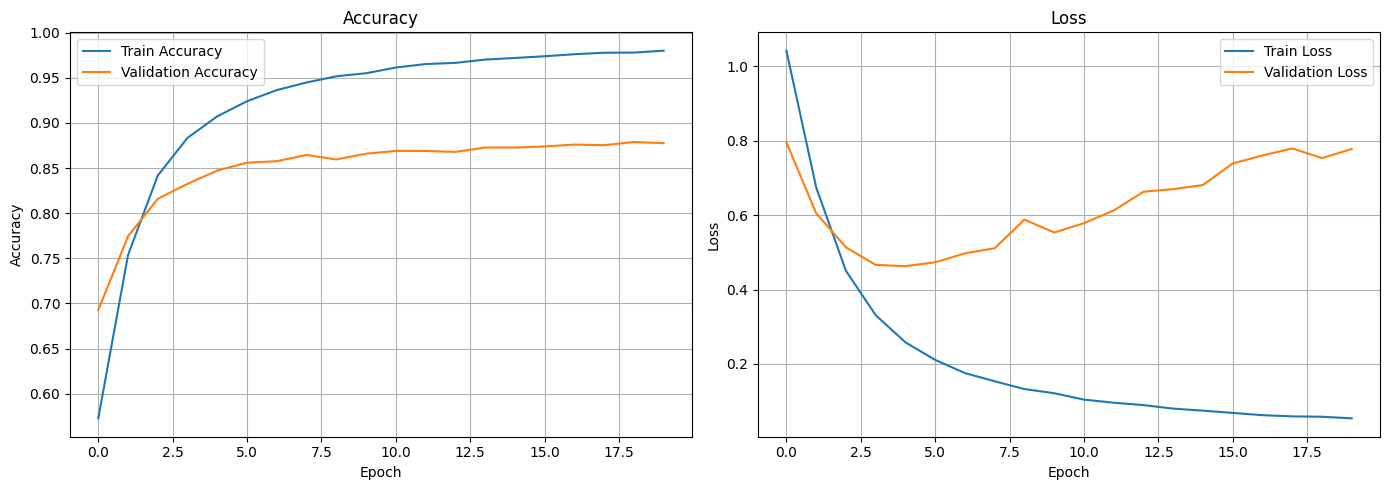

In [ ]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

13.Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8784 - loss: 0.7523
Test Accuracy: 0.88


11.Modeling Train a classifier

12.Model Building with Text Preprocessing